# Project 3

## Part 1 Data download

All these data is from https://data.mendeley.com/datasets/rscbjbr9sj/3, and uploaded to AWS S3

In [1]:
# Dependencies and Setup
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os
import urllib.request
from zipfile import ZipFile
import glob
from PIL import Image

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

import numpy as np

import split_folders

# ! pip install keras==2.3.0
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, Dropout, Flatten, BatchNormalization, Dense
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping, TensorBoard
import tensorflow as tf
# from tensorflow.keras.callbacks import TensorBoard

from sklearn.utils import class_weight
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

import random

Using TensorFlow backend.


In [ ]:
if not os.path.exists('data/chest_xray'):
    os.makedirs('./data', exist_ok=True)
    urllib.request.urlretrieve("https://project3-data.s3.amazonaws.com/chest_xray.zip", "data/chest_xray.zip")
    with ZipFile('data/chest_xray.zip', 'r') as zipObj:
# Extract all the contents of zip file in current directory
        zipObj.extractall(path='data/')
# Remove zip file
    os.remove('data/chest_xray.zip')

## Part 2 Retrieving the Data

In [2]:
path = 'data/chest_xray/'

n_normal = len(os.listdir(path + '/NORMAL'))
n_pneumonia = len(os.listdir(path + '/PNEUMONIA'))
print('normal images:'+ str(n_normal))
print('Pneumonia images:'+ str(n_pneumonia))

normal images:1583
Pneumonia images:4273


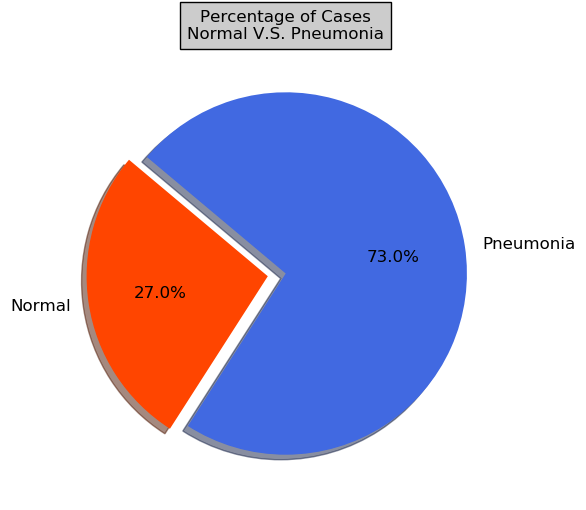

In [4]:
# Labels for the sections of our pie chart
labels = ["Normal", "Pneumonia"]
# The values of each section of the pie chart
sizes = [n_normal, n_pneumonia]
# Tells matplotlib to seperate the "Python" section from the others
explode = (0.1, 0)

colors = ['orangered', 'royalblue']
fig = plt.figure(figsize=(6, 6), dpi=100)
plt.pie(sizes, explode=explode, labels=labels, colors = colors, 
        autopct="%1.1f%%", shadow=True, startangle=140, textprops={'fontsize': 12})
plt.title("Percentage of Cases\n" + "Normal V.S. Pneumonia", bbox={'facecolor':'0.8', 'pad':5})
plt.show()
fig.savefig('output/model_image/pie.png')

#### Display Sample Image

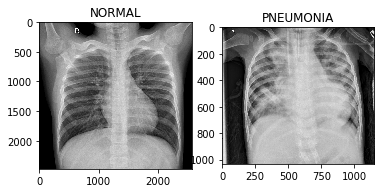

In [5]:
norm_img = plt.imread(path+'/NORMAL/'+os.listdir(path+'/NORMAL')[0])
pneu_img = plt.imread(path+'/PNEUMONIA/'+os.listdir(path+'/PNEUMONIA')[0])

plt.subplot(1,2,1).set_title('NORMAL')
plt.imshow(norm_img, cmap='gray')

plt.subplot(1,2,2).set_title('PNEUMONIA')
plt.imshow(pneu_img, cmap='gray')
plt.show()

## Part 3 Data Preprocess

### Split Input Folder

In [ ]:
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio('data/chest_xray', output="data/output", seed=1337, ratio=(.8, .1, .1)) # default values

In [6]:
# Distribution of our datasets
output_path = 'data/output/'
subdirectory_names = []
subdirectory_file_counts = []
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(output_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(output_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1267, pneumonia images: 3418
Set: val, normal images: 158, pneumonia images: 427
Set: test, normal images: 159, pneumonia images: 428


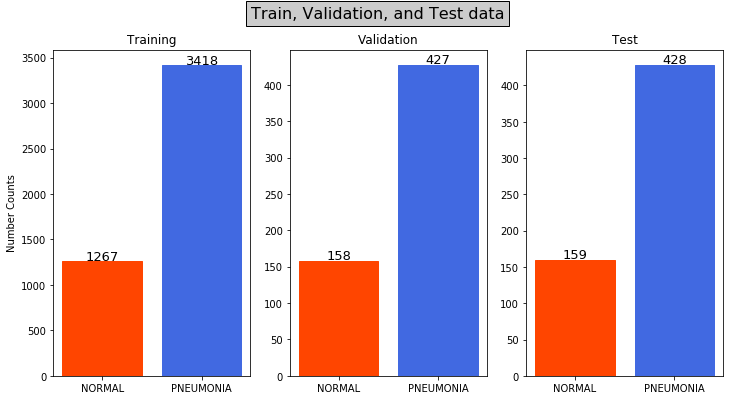

In [9]:
def subdir_file_count(master_dir):
    subdirs = os.listdir(master_dir)
    subdir_count = len(subdirs)

    subdir_names = []
    subdir_file_counts = []

    for subdir in subdirs:
        dir = os.path.join(master_dir, subdir)
        file_count = len(os.listdir(dir))
        subdir_names.append(subdir)
        subdir_file_counts.append(file_count)
    
    return subdir_names, subdir_file_counts


train_dir = 'data/output/train'
val_dir = 'data/output/val'
test_dir = 'data/output/test'


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

dir_name, dir_file_count = subdir_file_count(train_dir)
x = [i for i in dir_name]
y = dir_file_count

barlist = ax[0].bar(x, y)
barlist[0].set_color('orangered')
barlist[1].set_color('royalblue')
ax[0].set_title('Training')
ax[0].set(ylabel='Number Counts')
fig.suptitle('Train, Validation, and Test data', fontsize=16, bbox={'facecolor':'0.8', 'pad':5})
for p in ax[0].patches:
             ax[0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()+12),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 3), textcoords='offset points')

dir_name, dir_file_count = subdir_file_count(val_dir)
x = [i for i in dir_name]
y = dir_file_count

barlist = ax[1].bar(x, y)
barlist[0].set_color('orangered')
barlist[1].set_color('royalblue')
ax[1].set_title('Validation')
for p in ax[1].patches:
             ax[1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()+3),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 3), textcoords='offset points')
        
dir_name, dir_file_count = subdir_file_count(test_dir)
x = [i for i in dir_name]
y = dir_file_count

barlist = ax[2].bar(x, y)
barlist[0].set_color('orangered')
barlist[1].set_color('royalblue')
ax[2].set_title('Test')
for p in ax[2].patches:
             ax[2].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()+3),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 3), textcoords='offset points')
fig.savefig('output/model_image/bar.png')
plt.show()

### Loading Data into Keras Model
![Test Image 1](image/generator_structure.jpeg)

In [10]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2, # default value: 0.2
        horizontal_flip=True) # default value: horizontal_flip=True

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Hyperparameters
img_dims = 150
batch_size = 32
class_mode = "binary"


# Define Train Generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_dims, img_dims),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode= class_mode,
        shuffle=True,
        seed=42)

# Define Validation Generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_dims, img_dims),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode= class_mode,
        shuffle=True,
        seed=42)

# Define test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_dims, img_dims),
    color_mode="rgb",
    batch_size= 1,
    class_mode= class_mode,
    shuffle=False,
    seed=42)

Found 4686 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


In [12]:
class_weight =  class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
class_weight

array([1.8477918 , 0.68548859])

## Part 4 Building a model


Convolutional Neural Network (CNN, or ConvNet) seems to be obvious choice given recent achievements in image classification leveraging deep learning.

Since training of large neural networks takes immense amounts of computational power (not to mention time) we decide to use transfer learning. This concept boils down to reusing parts of the already trained networks in one domain to classify images in another domain. I our case we decided to use network trained on generic images from ImageNet database and tune it to detect pneumonia.

We leverage one of the most basic pre-trained networks called VGG16 

* Define Outputlayer
When loading a given model, the “include_top” argument can be set to False, in which case the fully-connected output layers of the model used to make predictions is not loaded, allowing a new output layer to be added and trained. 

In [13]:
K.clear_session()

NUM_CLASSES = 1

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In order to reduce number of trained parameters we will block first 20 layers of the model (up to the Flatten phase).

In [14]:
for layer in model.layers[0:20]:
    layer.trainable = False

for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_pool, trainable: False
layer 11: block4_conv1, trainable: False
layer 12: block4_conv2, trainable: False
layer 13: block4_conv3, trainable: False
layer 14: block4_pool, trainable: False
layer 15: block5_conv1, trainable: False
layer 16: block5_conv2, trainable: False
layer 17: block5_conv3, trainable: False
layer 18: block5_pool, trainable: False
layer 19: flatten_1, trainable: False
layer 20: dense_1, trainable: True
layer 21: dropout_1, trainable: True
layer 22: dense_2, trainable: True
layer 23: dropout_2, trainable: True
layer 24: dense_3, trainable: True


Here we use the "cross-entropy" loss function, which works well for learning probability distributions for classification.

See e.g.: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy

In [15]:
#complie the model
#RMSprop()
optimizer = keras.optimizers.Adam()

model.compile(loss='binary_crossentropy',     
              optimizer=optimizer, 
              metrics=['accuracy'])

### Define Callback

In [16]:
import time
import datetime
model_path = "output/model/"
log_path = "output/TensorBoardLog/"
# + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
# + time.strftime('%Y-%m-%d %H-%M-%S')
model_dir = model_path 
log_dir = log_path 

model_file = model_dir + "{epoch:02d}-val_acc-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5"

#ModelCheckpoint
checkPoint = ModelCheckpoint(
    model_file,
    monitor="val_acc",
    verbose=0,
    save_best_only=False,
    mode="auto"
)

#EarlyStopping
stopPoint = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    mode="auto",
    restore_best_weights=True
)

#ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    min_lr=0.0001,
    cooldown=2
)

tensorboard = TensorBoard(
    log_dir=log_dir,
    write_graph=True,
    update_freq="batch"
)

callback = [checkPoint, stopPoint, reduce_lr]

### Fitting/Training the model

In [26]:
# Define Step Size
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

hist = model.fit_generator(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=50,
        verbose=1,
        validation_data=validation_generator,
        validation_steps=STEP_SIZE_VALID,
        class_weight=class_weight,
        callbacks=callback)

Epoch 1/50
146/146 [==============================] - 279s 2s/step - loss: 0.3341 - accuracy: 0.8612 - val_loss: 0.0763 - val_accuracy: 0.9358
Epoch 2/50
146/146 [==============================] - 75s 512ms/step - loss: 0.2049 - accuracy: 0.9211 - val_loss: 0.1098 - val_accuracy: 0.8969
Epoch 3/50
146/146 [==============================] - 74s 507ms/step - loss: 0.1838 - accuracy: 0.9269 - val_loss: 0.1354 - val_accuracy: 0.9349
Epoch 4/50
146/146 [==============================] - 74s 504ms/step - loss: 0.1715 - accuracy: 0.9366 - val_loss: 0.1704 - val_accuracy: 0.9349
Epoch 5/50
146/146 [==============================] - 73s 502ms/step - loss: 0.1775 - accuracy: 0.9316 - val_loss: 0.1795 - val_accuracy: 0.9367
Epoch 6/50
146/146 [==============================] - 72s 493ms/step - loss: 0.1496 - accuracy: 0.9448 - val_loss: 0.1076 - val_accuracy: 0.9349
Epoch 7/50
146/146 [==============================] - 72s 490ms/step - loss: 0.1471 - accuracy: 0.9482 - val_loss: 0.1016 - val_accu

In [40]:
# Write History Log
import pickle
with open('output/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

In [20]:
import pickle
file = open('output/trainHistoryDict', 'rb') 
hist = pickle.load(file)
# hist

### Model Performance Visualization over the Epochs

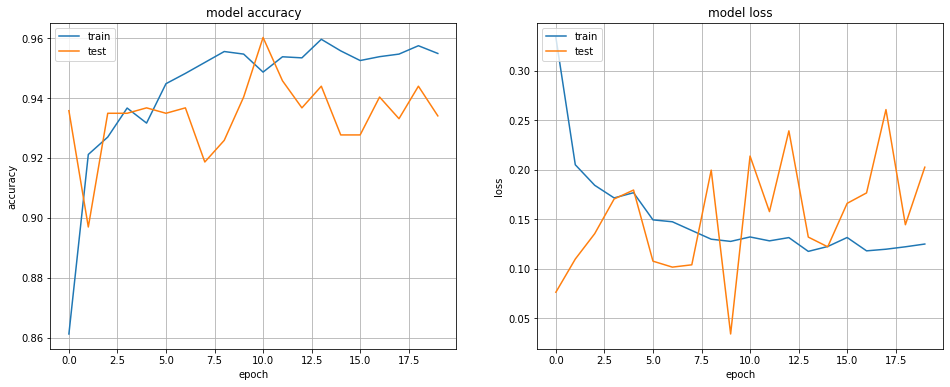

In [21]:
#
# plt.figure(figsize=(16,5))

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
# ax[0].plot(hist['accuracy'])
# ax[0].plot(hist['val_accuracy'])
# ax[0].set_title('Model Accuracy')
# ax[0].set(ylabel='accuracy')
# ax[0].set(xlabel='Epoch') 
# ax[0].grid() 
# ax[0].legend(['Train', 'Test'], loc='upper left')
# fig.suptitle('Model Accuacy V.S. Model Loss', fontsize=16, bbox={'facecolor':'0.8', 'pad':5})

# ax[1].plot(hist['loss'])
# ax[1].plot(hist['val_loss'])
# ax[1].set_title('Model Loss')
# ax[1].set(ylabel='Loss')
# ax[1].set(xlabel='Epoch') 
# ax[1].grid() 
# ax[1].legend(['Train', 'Test'], loc='upper left')

# plt.savefig('output/model_image/Performance.png')
# plt.show()

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid() 
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(1,2,2)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('output/model_image/Performance.png')
plt.show()

##### At epoch 10 the model has a intercept between train accuracy and test accuracy, we choose the model at this point from overfitting

### Saving a Trained Model

In [87]:
#Saved by Callback Function Already

### Loading a Model

In [23]:
# Load the model
model = keras.models.load_model("output/model/10-val_acc-0.94-val_loss-0.03.hdf5")

### Quantify our Trained Model

In [22]:
STEP_SIZE_VALID = test_generator.n
model_loss, model_accuracy = model.evaluate_generator(
    generator=test_generator,
    steps=STEP_SIZE_VALID,
    verbose=1)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

587/587 [==============================] - 9s 15ms/step
Normal Neural Network - Loss: 0.009954990819096565, Accuracy: 0.9522998332977295


### Predict the output

In [23]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n
y_pred_prob=model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)
y_pred = y_pred_prob.ravel()
y_pred_l = (y_pred > 0.5).astype(np.int)
y_pred_label=y_pred_l
y_true_label=test_generator.classes

587/587 [==============================] - 7s 13ms/step


In [24]:
precision = precision_score(y_true_label, y_pred_label) 
recall = recall_score(y_true_label, y_pred_label) 
f1 = f1_score(y_true_label, y_pred_label)

print("-"*40)
print("Derived Report")
print("-"*40)
print("%s%.3f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.3f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.3f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*40)

----------------------------------------
Derived Report
----------------------------------------
Precision     : 98.780%
Recall        : 94.626%
F1-Score      : 96.659%
----------------------------------------


### Confusion Matrix- Original

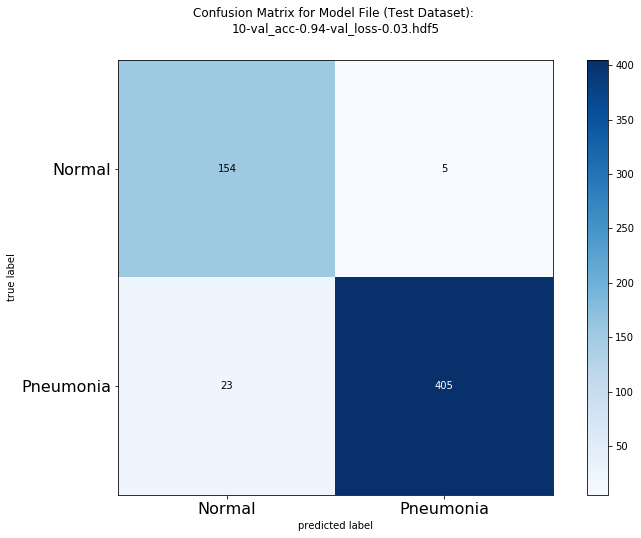

In [26]:
# Plot confusion matrix
CM = confusion_matrix(y_true_label, y_pred_label)

fig, ax = plot_confusion_matrix(CM , colorbar=True, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'] , fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'] , fontsize=16)
plt.title("Confusion Matrix for Model File (Test Dataset): \n"+"10-val_acc-0.94-val_loss-0.03.hdf5", fontsize=12)
plt.savefig('output/model_image/CM-Original.png')
plt.show()

In [27]:
class_report = classification_report(y_true_label, y_pred_label, target_names=['Normal', 'Pneumonia'])

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.87      0.97      0.92       159
   Pneumonia       0.99      0.95      0.97       428

    accuracy                           0.95       587
   macro avg       0.93      0.96      0.94       587
weighted avg       0.96      0.95      0.95       587

-------------------------------------------------------


### Confusion Matrix- Modified

In [29]:
# Since the model is designed to predict for pneumonia we want to lower the false negtive then we adjust the threshold value to 0.1 from 0.5
test_generator.reset()
STEP_SIZE_TEST=test_generator.n
y_pred_prob=model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)
y_pred = y_pred_prob.ravel()
y_pred_m = (y_pred > 0.1).astype(np.int)
y_pred_label=y_pred_m
y_true_label=test_generator.classes

587/587 [==============================] - 7s 12ms/step


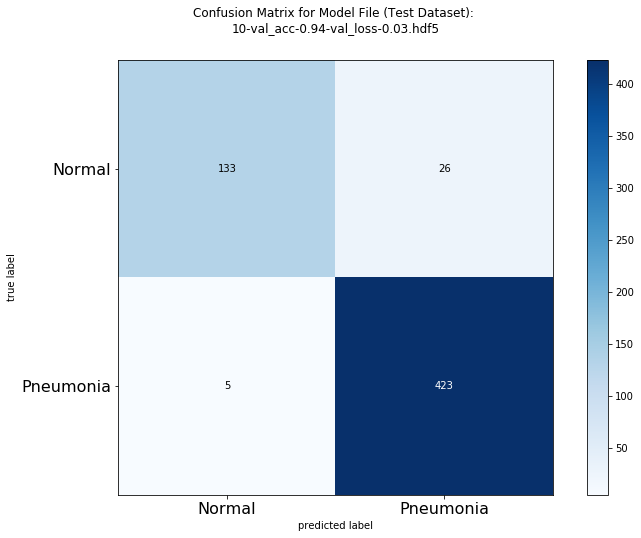

In [30]:
# Plot confusion matrix
CM = confusion_matrix(y_true_label, y_pred_label)

fig, ax = plot_confusion_matrix(CM , colorbar=True, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'] , fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'] , fontsize=16)
plt.title("Confusion Matrix for Model File (Test Dataset): \n"+"10-val_acc-0.94-val_loss-0.03.hdf5", fontsize=12)
plt.savefig('output/model_image/CM-Modified.png')
plt.show()

In [31]:
class_report = classification_report(y_true_label, y_pred_label, target_names=['Normal', 'Pneumonia'])

print("-"*55)
print("Report for Model File: ")
print("-"*55)
print(class_report)
print("-"*55)

-------------------------------------------------------
Report for Model File: 
-------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.96      0.84      0.90       159
   Pneumonia       0.94      0.99      0.96       428

    accuracy                           0.95       587
   macro avg       0.95      0.91      0.93       587
weighted avg       0.95      0.95      0.95       587

-------------------------------------------------------


### ROC Curve

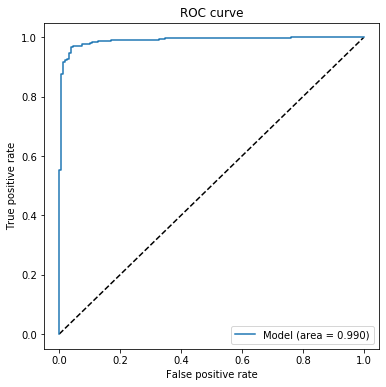

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_label, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('output/model_image/ROC.png')
plt.show()

### Visulization

In [34]:
from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [35]:
def param(ncols,count):
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    figsize = (20, ncols*nrows)
    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)

def selectFile(count):
    output_path = 'data/output/test'
    filename=[]
    final_files = {}
    
    for i in range(0,count):
        file = random.choice(['NORMAL','PNEUMONIA'])
        selected_files = random.sample(os.listdir(output_path+"/"+file),1)
        final_files[i]=([file,selected_files])
        filename.append(file+"\\"+selected_files[0])
    return (filename,final_files)

def prediction(filename):
    prediction = []
    
    for m in filename:
        predict_value = ""
        selected_file_pred = y_pred_label[test_generator.filenames.index(m)]
        if selected_file_pred == 0:
            predict_value = "NORMAL"
        else: predict_value = "PNEUMONIA"
        prediction.append(predict_value)
    return (prediction)

def plot(count,ncols):
    output_path = 'data/output/test'
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    input_fileName = selectFile(count)
    
    input_predictName = prediction(input_fileName[0])
    
    param(ncols,count)
    
    
    i=0
    for j in input_fileName[1]:
        plt.subplot(nrows, ncols, i+1)
        title_text = ("%s%s%s%s%s"%("True: ", input_fileName[1][j][0], "\n", "Pred: ", input_predictName[j]))
        if input_fileName[1][j][0] == input_predictName[j]:
            plt.title(title_text)
        else: plt.title(title_text, color="red")
    
        img = mpimg.imread(output_path+"/"+input_fileName[1][j][0]+"/"+str(input_fileName[1][j][1][0]))
        plt.imshow(img, cmap='gray')
        i=i+1
    
    plt.tight_layout()
    plt.show()

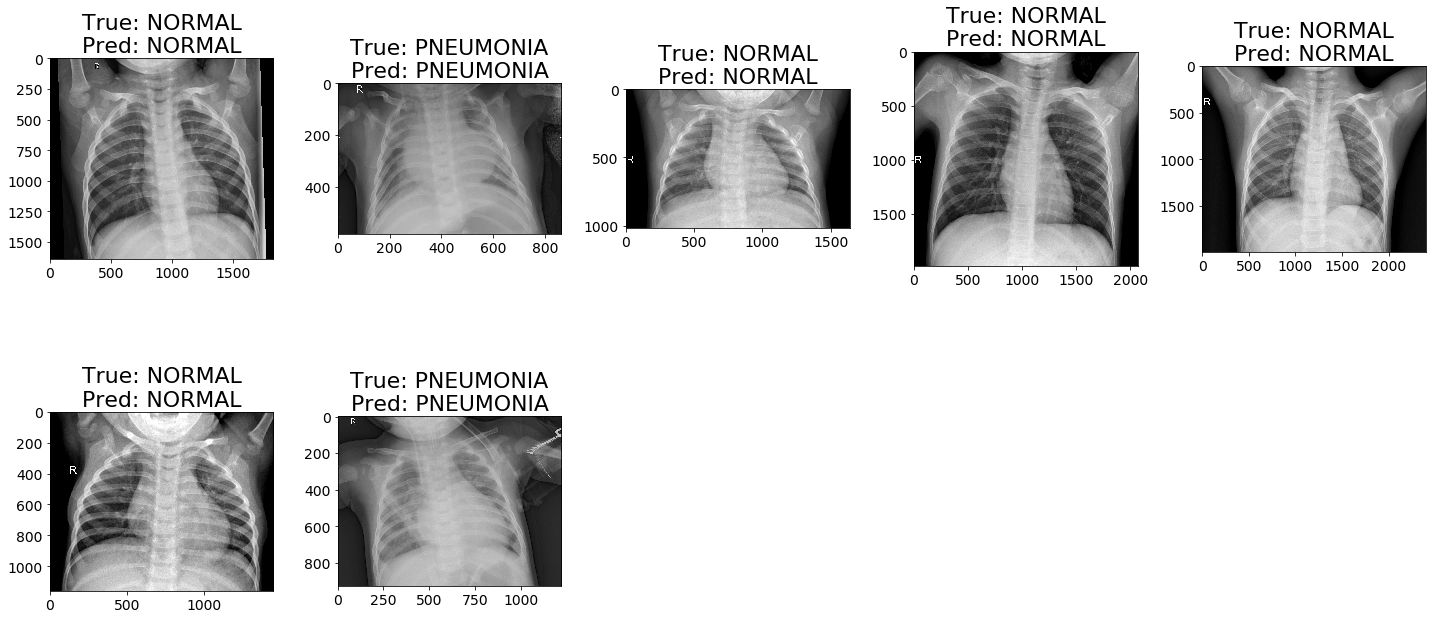

<Figure size 1440x720 with 0 Axes>

In [36]:
plot(7,5)
plt.savefig('output/model_image/7-5.png')

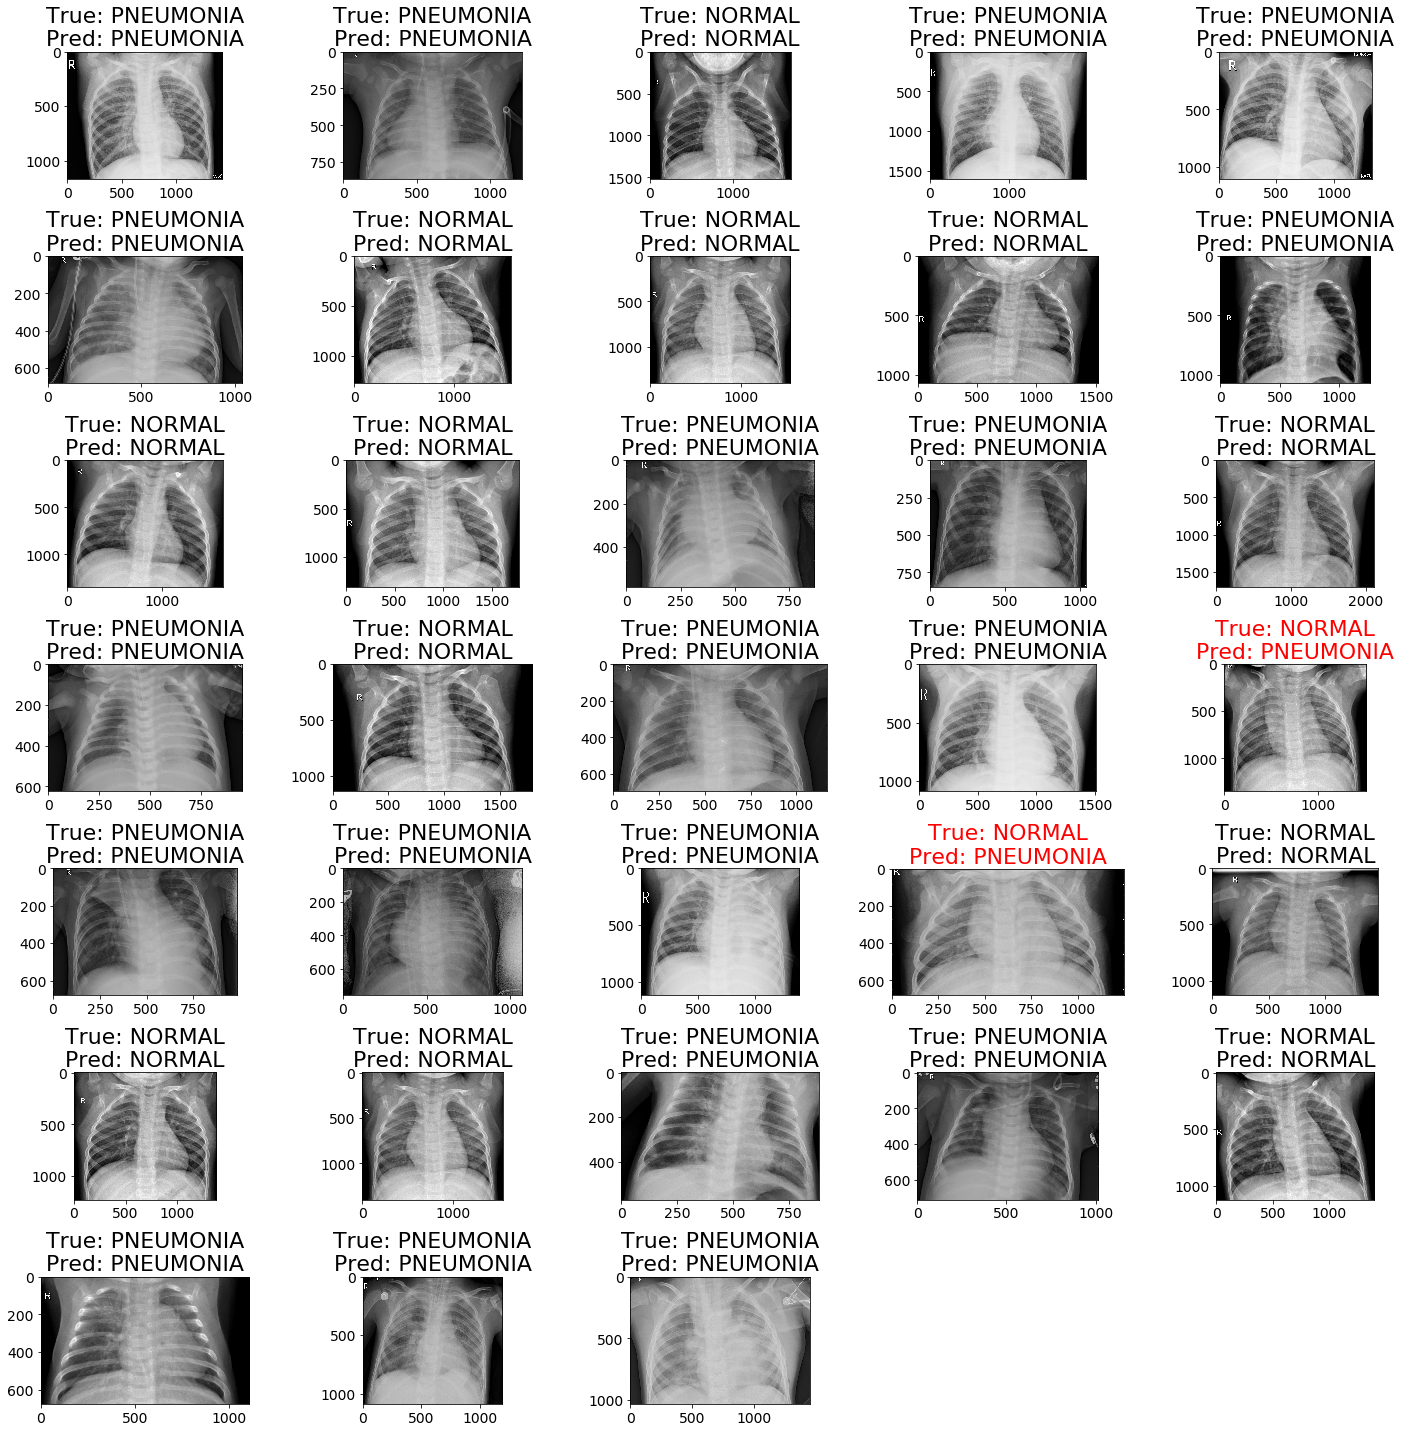

<Figure size 1440x2520 with 0 Axes>

In [37]:
plt.figure(figsize=(20,20))
plot(33,5)
plt.savefig('output/model_image/33-5.png')